# Data Preprocessing

将遥感数据进行切割，patch size 大小确定，然后根据图像进行分割，然后每五个patch中有一个放到validation set，时间上不分开


train_folder = "output_patches/train"
val_folder = "output_patches/val"

patch_{y}_{x}.tif 标记位置

In [14]:
import os
import random
from osgeo import gdal

# 输入影像路径
input_file = "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/data/source/remote_sensing/Causal_MSI_2020.tif"
output_folder = "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/data/intermediate/"
train_folder = "output_patches/train"
val_folder = "output_patches/val"
patch_size = 60  # 每个 patch 的大小

# 打开输入影像
dataset = gdal.Open(input_file)
if not dataset:
    raise ValueError(f"无法打开文件 {input_file}")

band_count = dataset.RasterCount  # 总波段数
width = dataset.RasterXSize  # 影像宽度
height = dataset.RasterYSize  # 影像高度
geo_transform = dataset.GetGeoTransform()  # 获取地理参考信息
projection = dataset.GetProjection()  # 获取投影信息

# 创建输出文件夹
os.makedirs(output_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

# 用于验证集固定划分的 seed（确保划分结果可复现）
random.seed(42)

# 遍历影像并切分为 patch
patch_index = 0
for y in range(0, height, patch_size):
    for x in range(0, width, patch_size):
        # 检查 patch 是否超出影像范围
        if y + patch_size > height or x + patch_size > width:
            continue

        # 按照一定比例划分为训练集和验证集
        is_validation = patch_index % 5 == 0  # 每五个 patch 中固定 1 个分配给验证集
        output_subfolder = val_folder if is_validation else train_folder

        # 创建输出 patch 文件路径
        patch_filename = os.path.join(output_subfolder, f"patch_{y}_{x}.tif")

        # 创建 Patch 的输出影像
        driver = gdal.GetDriverByName("GTiff")
        patch_dataset = driver.Create(
            patch_filename, patch_size, patch_size, band_count, gdal.GDT_Float32
        )
        patch_geo_transform = (
            geo_transform[0] + x * geo_transform[1],
            geo_transform[1],
            geo_transform[2],
            geo_transform[3] + y * geo_transform[5],
            geo_transform[4],
            geo_transform[5],
        )
        patch_dataset.SetGeoTransform(patch_geo_transform)
        patch_dataset.SetProjection(projection)

        # 提取每个波段的数据并写入
        for i in range(1, band_count + 1):
            band = dataset.GetRasterBand(i)
            patch_data = band.ReadAsArray(x, y, patch_size, patch_size)

            # 写入数据到新波段
            output_band = patch_dataset.GetRasterBand(i)
            output_band.WriteArray(patch_data)

            # 保留波段描述信息
            band_description = band.GetDescription()
            if band_description:
                output_band.SetDescription(band_description)

        patch_dataset = None  # 保存并关闭当前 patch
        patch_index += 1  # 更新 patch 索引

print("训练集与验证集切片完成。")

训练集与验证集切片完成。


输出patch，然后每个图片都切成对应的格式， 输出{patch_name}_time_{time_key}.tif 主要用于baseline的数据

In [17]:
from osgeo import gdal
import os
import numpy as np


def classify_bands_by_time(input_file, output_directory="output_time_bands"):
    """
    Classify bands from a multi-band image into groups based on time (e.g., _00, _01, etc.),
    and save the bands for each time step into separate directories.

    Parameters:
    input_file (str): Path to the input multi-band image file.
    output_directory (str): Directory where the classified bands will be saved.

    The function creates subdirectories for each time step (_00, _01, etc.) and saves the bands accordingly.
    """
    # 创建输出目录（如果不存在）
    os.makedirs(output_directory, exist_ok=True)
    patch_name = os.path.splitext(os.path.basename(input_file))[0]
    # 打开多波段影像
    dataset = gdal.Open(input_file)
    if not dataset:
        raise FileNotFoundError(f"无法打开文件: {input_file}")

    # 获取影像的波段数量
    band_count = dataset.RasterCount
    print(f"总共有 {band_count} 个波段。")

    # 初始化一个字典来存储按时间分类的波段
    time_band_mapping = {}

    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription() or f"Band_{i}"

        if "_" in band_name:
            time_key = band_name.split("_")[-1]  # 提取最后的部分作为时间
            if time_key not in time_band_mapping:
                time_band_mapping[time_key] = []
            time_band_mapping[time_key].append((i, band_name))  # 存储波段索引和名称
        else:
            cls_name = (i, band_name)
            # raise ValueError(f"无法从波段名称中提取时间信息: {band_name}")

    # 按时间保存每个组的波段
    for time_key, bands in time_band_mapping.items():
        output_path = os.path.join(
            output_directory, f"{patch_name}_time_{time_key}.tif"
        )
        print(f"正在处理时间: {time_key}, 包含 {len(bands)} 个波段。")

        # 假设所有波段的维度一致，从第一个波段读取形状
        first_band_index = bands[0][0]
        first_band = dataset.GetRasterBand(first_band_index)
        rows, cols = first_band.YSize, first_band.XSize

        # 创建多波段 TIFF 文件
        driver = gdal.GetDriverByName("GTiff")
        out_dataset = driver.Create(
            output_path, cols, rows, len(bands) + 1, gdal.GDT_Float32
        )

        for i, (band_index, band_name) in enumerate(bands, start=1):
            band = dataset.GetRasterBand(band_index)
            band_data = band.ReadAsArray()  # 波段数据 (2D NumPy 数组)

            # 数据归一化，忽略 NaN
            band_min = np.nanmin(band_data)  # 忽略 NaN 计算最小值
            band_max = np.nanmax(band_data)  # 忽略 NaN 计算最大值

            # 防止分母为 0 的情况（band_min == band_max）
            if band_max - band_min == 0:
                normalized_band = np.zeros_like(
                    band_data
                )  # 如果所有值都相等，归一化后为 0
            else:
                normalized_band = (band_data - band_min) / (band_max - band_min)

            normalized_band = np.where(
                np.isnan(normalized_band), np.nan, normalized_band.astype(np.float32)
            )

            # 写入对应的波段
            out_band = out_dataset.GetRasterBand(i)
            out_band.WriteArray(normalized_band)
            out_band.SetDescription(band_name)  # 设置波段名称
            print(f"已写入波段: {band_name}")

        out_band = out_dataset.GetRasterBand(len(bands) + 1)
        band = dataset.GetRasterBand(cls_name[0])
        band_data = band.ReadAsArray()
        out_band.WriteArray(band_data)
        out_band.SetDescription(cls_name[1])

        out_dataset.FlushCache()
        print(f"已保存时间 {time_key} 的所有波段到文件: {output_path}")
        out_dataset = None


def process_all_tif_files(base_directory, output_root_directory):
    """
    扫描目录中的所有 .tif 文件并分类波段。

    Parameters:
    - base_directory (str): 包含 .tif 文件的根目录。
    - output_root_directory (str): 分类后的波段存放的根目录。
    """
    for root, _, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".tif"):
                input_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, base_directory)
                output_directory = os.path.join(output_root_directory, relative_path)

                print(f"正在处理文件: {input_file}")
                classify_bands_by_time(input_file, output_directory)


# 输入目录和输出目录
train_dir = "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_patches/train"
val_dir = "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_patches/val"
output_dir = "output_all_times"

# 处理 train 和 val 目录
process_all_tif_files(train_dir, os.path.join(output_dir, "train"))
process_all_tif_files(val_dir, os.path.join(output_dir, "val"))

正在处理文件: /home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_patches/train/patch_900_1980.tif
总共有 144 个波段。
正在处理时间: 00, 包含 11 个波段。
已写入波段: B1_00
已写入波段: B2_00
已写入波段: B3_00
已写入波段: B4_00
已写入波段: B5_00
已写入波段: B6_00
已写入波段: B7_00
已写入波段: B8_00
已写入波段: B8A_00
已写入波段: B11_00
已写入波段: B12_00
已保存时间 00 的所有波段到文件: output_all_times/train/./patch_900_1980_time_00.tif
正在处理时间: 01, 包含 11 个波段。
已写入波段: B1_01
已写入波段: B2_01
已写入波段: B3_01
已写入波段: B4_01
已写入波段: B5_01
已写入波段: B6_01
已写入波段: B7_01
已写入波段: B8_01
已写入波段: B8A_01
已写入波段: B11_01
已写入波段: B12_01
已保存时间 01 的所有波段到文件: output_all_times/train/./patch_900_1980_time_01.tif
正在处理时间: 02, 包含 11 个波段。
已写入波段: B1_02
已写入波段: B2_02
已写入波段: B3_02
已写入波段: B4_02
已写入波段: B5_02
已写入波段: B6_02
已写入波段: B7_02
已写入波段: B8_02
已写入波段: B8A_02
已写入波段: B11_02
已写入波段: B12_02
已保存时间 02 的所有波段到文件: output_all_times/train/./patch_900_1980_time_02.tif
正在处理时间: 03, 包含 11 个波段。
已写入波段: B1_03
已写入波段: B2_03
已写入波段: B3_03
已写入波段: B4_03
已写入波段: B5_03
已写入波段: B6_03
已写入波段: B7_03
已写入波段: B8_03
已写入波段: B8A_03
已写入波段: B11

/tmp/ipykernel_2313107/2122579786.py:70: RuntimeWarning: All-NaN slice encountered
  band_min = np.nanmin(band_data)  # 忽略 NaN 计算最小值
/tmp/ipykernel_2313107/2122579786.py:71: RuntimeWarning: All-NaN slice encountered
  band_max = np.nanmax(band_data)  # 忽略 NaN 计算最大值


已写入波段: B6_04
已写入波段: B7_04
已写入波段: B8_04
已写入波段: B8A_04
已写入波段: B11_04
已写入波段: B12_04
已保存时间 04 的所有波段到文件: output_all_times/train/./patch_0_840_time_04.tif
正在处理时间: 05, 包含 11 个波段。
已写入波段: B1_05
已写入波段: B2_05
已写入波段: B3_05
已写入波段: B4_05
已写入波段: B5_05
已写入波段: B6_05
已写入波段: B7_05
已写入波段: B8_05
已写入波段: B8A_05
已写入波段: B11_05
已写入波段: B12_05
已保存时间 05 的所有波段到文件: output_all_times/train/./patch_0_840_time_05.tif
正在处理时间: 06, 包含 11 个波段。
已写入波段: B1_06
已写入波段: B2_06
已写入波段: B3_06
已写入波段: B4_06
已写入波段: B5_06
已写入波段: B6_06
已写入波段: B7_06
已写入波段: B8_06
已写入波段: B8A_06
已写入波段: B11_06
已写入波段: B12_06
已保存时间 06 的所有波段到文件: output_all_times/train/./patch_0_840_time_06.tif
正在处理时间: 07, 包含 11 个波段。
已写入波段: B1_07
已写入波段: B2_07
已写入波段: B3_07
已写入波段: B4_07
已写入波段: B5_07
已写入波段: B6_07
已写入波段: B7_07
已写入波段: B8_07
已写入波段: B8A_07
已写入波段: B11_07
已写入波段: B12_07
已保存时间 07 的所有波段到文件: output_all_times/train/./patch_0_840_time_07.tif
正在处理时间: 08, 包含 11 个波段。
已写入波段: B1_08
已写入波段: B2_08
已写入波段: B3_08
已写入波段: B4_08
已写入波段: B5_08
已写入波段: B6_08
已写入波段: B7_08
已写入波段: B8_08
已写入波段: B8A_08

新的数据，切是一样的，但是时间序列要合在一起，对于时间windows 可以定义

In [ ]:
from osgeo import gdal
import os
import numpy as np


def extract_band_with_time_windows(
    input_file, output_directory="output_time_with_windows_", num_time_windows=3
):
    """
    Classify bands from a multi-band image into groups based on time (e.g., _00, _01, etc.),
    and save the bands for each time step into separate directories.

    Parameters:
    input_file (str): Path to the input multi-band image file.
    output_directory (str): Directory where the classified bands will be saved.

    The function creates subdirectories for each time step (_00, _01, etc.) and saves the bands accordingly.
    """
    # 创建输出目录（如果不存在）
    os.makedirs(output_directory, exist_ok=True)
    patch_name = os.path.splitext(os.path.basename(input_file))[0]
    # 打开多波段影像
    dataset = gdal.Open(input_file)
    if not dataset:
        return None

    # 获取影像的波段数量
    band_count = dataset.RasterCount
    print(f"总共有 {band_count} 个波段。")

    # 初始化一个字典来存储按时间分类的波段
    time_band_mapping = {}

    # 遍历每个波段，提取时间信息，并分类
    for i in range(1, band_count + 1):  # gdal 的波段索引从 1 开始
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription() or f"Band_{i}"  # 获取波段名称或默认名称

        # 提取时间信息（假设格式为 B2_03，其中 _03 是时间）
        if "_" in band_name:
            time_key = band_name.split("_")[-1]  # 提取最后的部分作为时间
            if time_key not in time_band_mapping:
                time_band_mapping[time_key] = []
            time_band_mapping[time_key].append((i, band_name))  # 存储波段索引和名称
        else:
            cls_name = (i, band_name)
            # raise ValueError(f"无法从波段名称中提取时间信息: {band_name}")

    time_band_mapping = dict(sorted(time_band_mapping.items()))
    time_span = len(time_band_mapping)

    # 对所有的time 进行遍历，设置为初始time_index
    time_keys_list = list(time_band_mapping.keys())

    for time_index, time_key in enumerate(time_keys_list):
        output_path = os.path.join(
            output_directory, f"{patch_name}_time_{time_key}.tif"
        )
        if time_index + num_time_windows < time_span:
            first_band_index = time_band_mapping[time_key][0][0]
            first_band = dataset.GetRasterBand(first_band_index)
            rows, cols = first_band.YSize, first_band.XSize

            driver = gdal.GetDriverByName("GTiff")
            out_dataset = driver.Create(
                output_path,
                cols,
                rows,
                len(time_band_mapping[time_key]) * num_time_windows + 1,
                gdal.GDT_Float32,
            )
            band_index_global = 1
            for t in range(num_time_windows):
                band_time_key = time_keys_list[time_index + t]
                bands = time_band_mapping[band_time_key][0][0]
                # 将每个时间段进行填写
                for i, (band_index, band_name) in enumerate(
                    time_band_mapping[band_time_key], start=1
                ):
                    band = dataset.GetRasterBand(band_index)
                    band_data = band.ReadAsArray()  # 波段数据 (2D NumPy 数组)

                    # 数据归一化，忽略 NaN
                    band_min = np.nanmin(band_data)  # 忽略 NaN 计算最小值
                    band_max = np.nanmax(band_data)  # 忽略 NaN 计算最大值

                    # 防止分母为 0 的情况（band_min == band_max）
                    if band_max - band_min == 0:
                        normalized_band = np.zeros_like(
                            band_data
                        )  # 如果所有值都相等，归一化后为 0
                    else:
                        normalized_band = (band_data - band_min) / (band_max - band_min)

                    normalized_band = np.where(
                        np.isnan(normalized_band),
                        np.nan,
                        normalized_band.astype(np.float32),
                    )

                    # 写入对应的波段
                    out_band = out_dataset.GetRasterBand(band_index_global)
                    out_band.WriteArray(normalized_band)
                    out_band.SetDescription(band_name)  # 设置波段名称
                    print(f"已写入波段: {band_name}")
                    band_index_global += 1

            out_band = out_dataset.GetRasterBand(band_index_global)
            band = dataset.GetRasterBand(cls_name[0])
            band_data = band.ReadAsArray()
            out_band.WriteArray(band_data)
            out_band.SetDescription(cls_name[1])

            out_dataset.FlushCache()
            print(f"已保存时间 {time_key} 的所有波段到文件: {output_path}")
            out_dataset = None


def normalize_band(dataset, band_index):
    band = dataset.GetRasterBand(band_index)
    band_data = band.ReadAsArray()
    band_min = np.nanmin(band_data)
    band_max = np.nanmax(band_data)
    if band_max - band_min == 0:
        normalized_band = np.zeros_like(band_data)
    else:
        # Normalize the data
        normalized_band = (band_data - band_min) / (band_max - band_min)

    normalized_band = np.where(
        np.isnan(normalized_band),
        np.nan,
        normalized_band.astype(np.float32),
    )

    return normalized_band


def extract_band_with_max_time_windows(
    input_file,
    output_directory="output_time_with_windows_max_",
    max_pooling_window=2,
):
    # 创建输出目录（如果不存在）
    os.makedirs(output_directory, exist_ok=True)
    patch_name = os.path.splitext(os.path.basename(input_file))[0]
    # 打开多波段影像
    dataset = gdal.Open(input_file)
    if not dataset:
        return None

    band_count = dataset.RasterCount
    time_band_mapping = {}

    # 遍历每个波段，提取时间信息，并分类
    for i in range(1, band_count + 1):  # gdal 的波段索引从 1 开始
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription() or f"Band_{i}"  # 获取波段名称或默认名称

        # 提取时间信息（假设格式为 B2_03，其中 _03 是时间）
        if "_" in band_name:
            time_key = band_name.split("_")[-1]  # 提取最后的部分作为时间
            if time_key not in time_band_mapping:
                time_band_mapping[time_key] = []
            time_band_mapping[time_key].append((i, band_name))  # 存储波段索引和名称
        else:
            cls_name = (i, band_name)
            # raise ValueError(f"无法从波段名称中提取时间信息: {band_name}")

    time_band_mapping = dict(sorted(time_band_mapping.items()))
    time_span = len(time_band_mapping)

    # 对所有的time 进行遍历，设置为初始time_index
    time_keys_list = list(time_band_mapping.keys())
    time_span_every_tiff = time_span // max_pooling_window

    for i, (time_key) in enumerate(time_keys_list):  # 每个时间做遍历，以2为一个stepsize
        output_path = os.path.join(
            output_directory, f"{patch_name}_time_{time_key}.tif"
        )
        if i % 2 != 0:
            continue
        else:
            # 如果能够向后展开为 num_time_windows的时间序列
            if i + max_pooling_window < time_span:
                # 假设所有波段的维度一致，从第一个波段读取形状
                first_band_index = time_band_mapping[time_key][0][0]
                first_band = dataset.GetRasterBand(first_band_index)
                rows, cols = first_band.YSize, first_band.XSize

                # 创建多波段 TIFF 文件 并初始化
                driver = gdal.GetDriverByName("GTiff")
                out_dataset = driver.Create(
                    output_path,
                    cols,
                    rows,
                    len(time_band_mapping[time_key]) * (time_span_every_tiff) + 1,
                    gdal.GDT_Float32,
                )
                band_index_global = 1

                band_time_key = time_keys_list[i]
                band_time_key_next = time_keys_list[i + 1]
                for i in range(len(time_band_mapping[band_time_key])):
                    band_index, band_name = time_band_mapping[band_time_key][i]
                    band_index_next, band_name_next = time_band_mapping[
                        band_time_key_next
                    ][i]

                    normalized_band = normalize_band(dataset, band_index)
                    normalized_band_next = normalize_band(dataset, band_index_next)

                    out_band = np.maximum(normalized_band, normalized_band_next)
                    out_band = out_dataset.GetRasterBand(band_index_global)
                    out_band.FF(normalized_band)
                    out_band.SetDescription(f"{band_name}_{band_name_next}")
                    band_index_global += 1

    out_band = out_dataset.GetRasterBand(band_index_global)
    band = dataset.GetRasterBand(cls_name[0])
    band_data = band.ReadAsArray()
    out_band.WriteArray(band_data)
    out_band.SetDescription(cls_name[1])

    out_dataset.FlushCache()
    print(f"已保存时间 {time_key} 的所有波段到文件: {output_path}")
    out_dataset = None


def process_all_tif_files(base_directory, output_root_directory):
    """
    扫描目录中的所有 .tif 文件并分类波段。

    Parameters:
    - base_directory (str): 包含 .tif 文件的根目录。
    - output_root_directory (str): 分类后的波段存放的根目录。
    """
    for root, _, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".tif"):
                input_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, base_directory)
                output_directory = os.path.join(output_root_directory, relative_path)

                print(f"正在处理文件: {input_file}")
                extract_band_with_max_time_windows(input_file, output_directory)


# 输入目录和输出目录
train_dir = "/home/snt/projects_lujun/vitCausalSeries/output_patches/train"
val_dir = "/home/snt/projects_lujun/vitCausalSeries/output_patches/val"
output_dir = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_with_time_series_max"

# 处理 train 和 val 目录
process_all_tif_files(train_dir, os.path.join(output_dir, "train"))
process_all_tif_files(val_dir, os.path.join(output_dir, "val"))

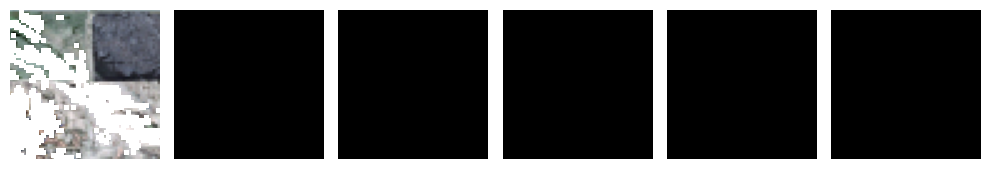

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal


def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription()
        band_data = band.ReadAsArray()
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


tiff = read_tiff(
    "/home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_with_time_series_max/train/patch_0_840_time_00.tif"
)


channel_list = [3, 2, 1]
channels, h, w = tiff.shape
time_span = int((channels - 1) / 11)
images = np.split(tiff, [11 * (i + 1) for i in range(time_span)], axis=0)
time_series_images = []
for i, image in enumerate(images[:-1]):
    image = np.transpose(image, (1, 2, 0))
    pseudo_color_image = image[:, :, channel_list]
    time_series_images.append(pseudo_color_image)

fig, axes = plt.subplots(1, len(time_series_images), figsize=(10, 10))

for j in range(len(time_series_images)):
    axes[j].imshow(time_series_images[j], cmap="gray")  # 修正索引方式
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from osgeo import gdal
import os
import numpy as np


def extract_band_with_time_windows_and_mask(
    input_file, output_directory="output_time_with_windows_", num_time_windows=3
):
    """
    Classify bands from a multi-band image into groups based on time (e.g., _00, _01, etc.),
    and save the bands for each time step into separate directories.

    Parameters:
    input_file (str): Path to the input multi-band image file.
    output_directory (str): Directory where the classified bands will be saved.

    The function creates subdirectories for each time step (_00, _01, etc.) and saves the bands accordingly.
    """
    # 创建输出目录（如果不存在）
    os.makedirs(output_directory, exist_ok=True)
    patch_name = os.path.splitext(os.path.basename(input_file))[0]
    # 打开多波段影像
    dataset = gdal.Open(input_file)
    if not dataset:
        return None

    # 获取影像的波段数量
    band_count = dataset.RasterCount
    print(f"总共有 {band_count} 个波段。")

    # 初始化一个字典来存储按时间分类的波段
    time_band_mapping = {}

    # 遍历每个波段，提取时间信息，并分类
    for i in range(1, band_count + 1):  # gdal 的波段索引从 1 开始
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription() or f"Band_{i}"  # 获取波段名称或默认名称

        # 提取时间信息（假设格式为 B2_03，其中 _03 是时间）
        if "_" in band_name:
            time_key = band_name.split("_")[-1]  # 提取最后的部分作为时间
            if time_key not in time_band_mapping:
                time_band_mapping[time_key] = []
            time_band_mapping[time_key].append((i, band_name))  # 存储波段索引和名称
        else:
            cls_name = (i, band_name)
            # raise ValueError(f"无法从波段名称中提取时间信息: {band_name}")

    time_band_mapping = dict(sorted(time_band_mapping.items()))
    time_span = len(time_band_mapping)

    # 对所有的time 进行遍历，设置为初始time_index
    time_keys_list = list(time_band_mapping.keys())

    for time_index, time_key in enumerate(time_keys_list):
        output_path = os.path.join(
            output_directory, f"{patch_name}_time_{time_key}.tif"
        )
        # 如果能够向后展开为 num_time_windows的时间序列
        if time_index + num_time_windows < time_span:
            # 假设所有波段的维度一致，从第一个波段读取形状
            first_band_index = time_band_mapping[time_key][0][0]
            first_band = dataset.GetRasterBand(first_band_index)
            rows, cols = first_band.YSize, first_band.XSize

            # 创建多波段 TIFF 文件 并初始化
            driver = gdal.GetDriverByName("GTiff")
            out_dataset = driver.Create(
                output_path,
                cols,
                rows,
                len(time_band_mapping[time_key]) * num_time_windows + 1,
                gdal.GDT_Float32,
            )
            band_index_global = 1
            for t in range(num_time_windows):
                band_time_key = time_keys_list[time_index + t]
                bands = time_band_mapping[band_time_key][0][0]
                # 将每个时间段进行填写
                for i, (band_index, band_name) in enumerate(
                    time_band_mapping[band_time_key], start=1
                ):
                    band = dataset.GetRasterBand(band_index)
                    band_data = band.ReadAsArray()  # 波段数据 (2D NumPy 数组)

                    # 数据归一化，忽略 NaN
                    band_min = np.nanmin(band_data)  # 忽略 NaN 计算最小值
                    band_max = np.nanmax(band_data)  # 忽略 NaN 计算最大值

                    # 防止分母为 0 的情况（band_min == band_max）
                    if band_max - band_min == 0:
                        normalized_band = np.zeros_like(
                            band_data
                        )  # 如果所有值都相等，归一化后为 0
                    else:
                        normalized_band = (band_data - band_min) / (band_max - band_min)

                    normalized_band = np.where(
                        np.isnan(normalized_band),
                        np.nan,
                        normalized_band.astype(np.float32),
                    )

                    # 写入对应的波段
                    out_band = out_dataset.GetRasterBand(band_index_global)
                    out_band.WriteArray(normalized_band)
                    out_band.SetDescription(band_name)  # 设置波段名称
                    print(f"已写入波段: {band_name}")
                    band_index_global += 1

            out_band = out_dataset.GetRasterBand(band_index_global)
            band = dataset.GetRasterBand(cls_name[0])
            band_data = band.ReadAsArray()
            out_band.WriteArray(band_data)
            out_band.SetDescription(cls_name[1])

            out_dataset.FlushCache()
            print(f"已保存时间 {time_key} 的所有波段到文件: {output_path}")
            out_dataset = None


def extract_band_with_time_windows(
    input_file, output_directory="output_time_with_windows_", num_time_windows=3
):
    """
    Classify bands from a multi-band image into groups based on time (e.g., _00, _01, etc.),
    and save the bands for each time step into separate directories.

    Parameters:
    input_file (str): Path to the input multi-band image file.
    output_directory (str): Directory where the classified bands will be saved.

    The function creates subdirectories for each time step (_00, _01, etc.) and saves the bands accordingly.
    """
    # 创建输出目录（如果不存在）
    os.makedirs(output_directory, exist_ok=True)
    patch_name = os.path.splitext(os.path.basename(input_file))[0]
    # 打开多波段影像
    dataset = gdal.Open(input_file)
    if not dataset:
        return None

    # 获取影像的波段数量
    band_count = dataset.RasterCount
    print(f"总共有 {band_count} 个波段。")

    # 初始化一个字典来存储按时间分类的波段
    time_band_mapping = {}

    # 遍历每个波段，提取时间信息，并分类
    for i in range(1, band_count + 1):  # gdal 的波段索引从 1 开始
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription() or f"Band_{i}"  # 获取波段名称或默认名称

        # 提取时间信息（假设格式为 B2_03，其中 _03 是时间）
        if "_" in band_name:
            time_key = band_name.split("_")[-1]  # 提取最后的部分作为时间
            if time_key not in time_band_mapping:
                time_band_mapping[time_key] = []
            time_band_mapping[time_key].append((i, band_name))  # 存储波段索引和名称
        else:
            cls_name = (i, band_name)
            # raise ValueError(f"无法从波段名称中提取时间信息: {band_name}")

    time_band_mapping = dict(sorted(time_band_mapping.items()))
    time_span = len(time_band_mapping)

    # 对所有的time 进行遍历，设置为初始time_index
    time_keys_list = list(time_band_mapping.keys())

    for time_index, time_key in enumerate(time_keys_list):
        output_path = os.path.join(
            output_directory, f"{patch_name}_time_{time_key}.tif"
        )
        # 如果能够向后展开为 num_time_windows的时间序列
        if time_index + num_time_windows < time_span:
            # 假设所有波段的维度一致，从第一个波段读取形状
            first_band_index = time_band_mapping[time_key][0][0]
            first_band = dataset.GetRasterBand(first_band_index)
            rows, cols = first_band.YSize, first_band.XSize

            # 创建多波段 TIFF 文件 并初始化
            driver = gdal.GetDriverByName("GTiff")
            out_dataset = driver.Create(
                output_path,
                cols,
                rows,
                len(time_band_mapping[time_key]) * num_time_windows + 1,
                gdal.GDT_Float32,
            )
            band_index_global = 1
            for t in range(num_time_windows):
                band_time_key = time_keys_list[time_index + t]
                bands = time_band_mapping[band_time_key][0][0]
                # 将每个时间段进行填写
                for i, (band_index, band_name) in enumerate(
                    time_band_mapping[band_time_key], start=1
                ):
                    band = dataset.GetRasterBand(band_index)
                    band_data = band.ReadAsArray()  # 波段数据 (2D NumPy 数组)

                    # 数据归一化，忽略 NaN
                    band_min = np.nanmin(band_data)  # 忽略 NaN 计算最小值
                    band_max = np.nanmax(band_data)  # 忽略 NaN 计算最大值

                    # 防止分母为 0 的情况（band_min == band_max）
                    if band_max - band_min == 0:
                        normalized_band = np.zeros_like(
                            band_data
                        )  # 如果所有值都相等，归一化后为 0
                    else:
                        normalized_band = (band_data - band_min) / (band_max - band_min)

                    normalized_band = np.where(
                        np.isnan(normalized_band),
                        np.nan,
                        normalized_band.astype(np.float32),
                    )

                    # 写入对应的波段
                    out_band = out_dataset.GetRasterBand(band_index_global)
                    out_band.WriteArray(normalized_band)
                    out_band.SetDescription(band_name)  # 设置波段名称
                    print(f"已写入波段: {band_name}")
                    band_index_global += 1

            out_band = out_dataset.GetRasterBand(band_index_global)
            band = dataset.GetRasterBand(cls_name[0])
            band_data = band.ReadAsArray()
            out_band.WriteArray(band_data)
            out_band.SetDescription(cls_name[1])

            out_dataset.FlushCache()
            print(f"已保存时间 {time_key} 的所有波段到文件: {output_path}")
            out_dataset = None


def process_all_tif_files(base_directory, output_root_directory):
    """
    扫描目录中的所有 .tif 文件并分类波段。

    Parameters:
    - base_directory (str): 包含 .tif 文件的根目录。
    - output_root_directory (str): 分类后的波段存放的根目录。
    """
    for root, _, files in os.walk(base_directory):
        for file in files:
            if file.endswith(".tif"):
                input_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, base_directory)
                output_directory = os.path.join(output_root_directory, relative_path)

                print(f"正在处理文件: {input_file}")
                extract_band_with_time_windows(input_file, output_directory)


# 输入目录和输出目录
train_dir = "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/data/intermediate/output_patches/train"
val_dir = "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/data/intermediate/output_patches/val"
output_dir = "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/data/intermediate/output_with_time_series"

# 处理 train 和 val 目录
process_all_tif_files(train_dir, os.path.join(output_dir, "train"))
process_all_tif_files(val_dir, os.path.join(output_dir, "val"))

验证是否有mask 和空

In [ ]:
from osgeo import gdal
import numpy as np
import os


def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)  # 获取波段对象
        band_name = band.GetDescription()  # 获取波段的描述信息
        band_data = band.ReadAsArray()  # 读取波段数据为 NumPy 数组
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


folder_path = "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_all_times/val"

# 初始化包含 NaN 值的文件列表
nan_files = []

# 遍历文件夹中的所有文件
for file_name in os.listdir(folder_path):
    if file_name.endswith(".tif"):  # 判断文件是否为 .tif 文件
        file_path = os.path.join(folder_path, file_name)
        # try:
        # 读取 .tif 文件
        image = read_tiff(file_path)

        # 检查是否包含 NaN
        contains_nan = np.isnan(image).any()

        if contains_nan:
            print(f"文件 {file_name} 包含 NaN 值")
            nan_files.append(file_name)

## Testing Mask

In [1]:
from osgeo import gdal
import numpy as np
import os


def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)  # 获取波段对象
        band_name = band.GetDescription()  # 获取波段的描述信息
        band_data = band.ReadAsArray()  # 读取波段数据为 NumPy 数组
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


image = read_tiff(
    "/home/snt/projects_lujun/vitCausalSeries/data/intermediate/output_all_times/val/patch_0_0_time_00.tif"
)

In [2]:
image

array([[[       nan,        nan,        nan, ..., 0.49757046,
         0.49757046, 0.49757046],
        [       nan,        nan,        nan, ..., 0.49757046,
         0.49757046, 0.49757046],
        [       nan,        nan,        nan, ..., 0.3148688 ,
         0.3148688 , 0.3148688 ],
        ...,
        [       nan,        nan,        nan, ..., 0.2303207 ,
         0.18464528, 0.18464528],
        [       nan,        nan,        nan, ..., 0.25558794,
         0.15937804, 0.15937804],
        [       nan,        nan,        nan, ..., 0.25558794,
         0.15937804, 0.15937804]],

       [[       nan,        nan,        nan, ..., 0.3953108 ,
         0.40130863, 0.4187568 ],
        [       nan,        nan,        nan, ..., 0.31842965,
         0.35877863, 0.3625954 ],
        [       nan,        nan,        nan, ..., 0.23827699,
         0.3189749 , 0.29880044],
        ...,
        [       nan,        nan,        nan, ..., 0.19465649,
         0.23009814, 0.22737187],
        [   

## Testing Cloud

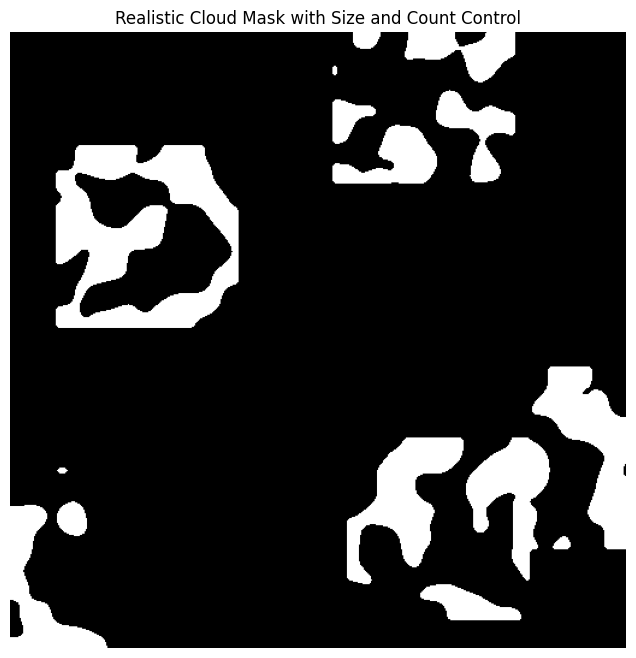

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


def generate_realistic_cloud_mask(
    shape=(512, 512), scale=10, threshold=0.5, blur=2, cloud_size=0.1, cloud_count=5
):
    """
    生成逼真的云掩膜，支持云的大小和数量控制。
    :param shape: 掩膜的形状 (高度, 宽度)
    :param scale: 控制云纹理的模糊程度
    :param threshold: 阈值，用于将噪声转换为二值掩膜
    :param blur: 模糊程度，用于平滑云边缘
    :param cloud_size: 单个云的相对大小（0到1之间）
    :param cloud_count: 云的数量
    :return: 云掩膜 (numpy 数组)
    """
    mask = np.zeros(shape)  # 初始化空白掩膜

    for _ in range(cloud_count):
        # 随机生成云的中心位置
        center_x = np.random.randint(0, shape[0])
        center_y = np.random.randint(0, shape[1])

        # 根据云大小生成单个云的形状
        cloud_shape = (int(shape[0] * cloud_size), int(shape[1] * cloud_size))
        noise = np.random.rand(*cloud_shape)
        smooth_noise = gaussian_filter(noise, sigma=scale)
        cloud = smooth_noise > threshold

        # 将云放置到掩膜中
        x_start = max(center_x - cloud_shape[0] // 2, 0)
        y_start = max(center_y - cloud_shape[1] // 2, 0)
        x_end = min(center_x + cloud_shape[0] // 2, shape[0])
        y_end = min(center_y + cloud_shape[1] // 2, shape[1])

        mask[x_start:x_end, y_start:y_end] = np.maximum(
            mask[x_start:x_end, y_start:y_end],
            cloud[: x_end - x_start, : y_end - y_start],
        )

    # 可选：进一步模糊边缘，使云更自然
    if blur > 0:
        mask = gaussian_filter(mask.astype(float), sigma=blur) > 0.5

    return mask


# 生成云掩膜并可视化
cloud_mask = generate_realistic_cloud_mask(cloud_size=0.3, cloud_count=5)

plt.figure(figsize=(8, 8))
plt.imshow(cloud_mask, cmap="gray")
plt.title("Realistic Cloud Mask with Size and Count Control")
plt.axis("off")
plt.show()